# Growth model (1 customer)


In [79]:
plt.rcParams['figure.dpi'] = 100  # Adjust DPI for inline figures

### SQL

**Activated**

9517e943-6c46-42b8-b617-5677b3dd963c

**Data needed**
- Revenue / transaction time series: 
    -  stg_mrr_workspace_changes_daily
    -  stg_workspace_utilisation_daily_v3
- Product time series
    - stg_workspace_metrics_daily

In [ ]:
with revenue as (
select dt as date, mrr_dt as mrr
FROM
  "dbt_staging"."stg_mrr_workspace_changes_daily"
  where workspace_id = '9517e943-6c46-42b8-b617-5677b3dd963c'
  and period_name = '1d'
  order by 1 desc
  ),
  
 price_vol as (
 select dt as date, subscription_started_at, max(seats) as quantity, max(mrr) as mrr
from  "dbt_staging"."stg_mrr_workspace_product_daily"
  where workspace_id = '9517e943-6c46-42b8-b617-5677b3dd963c'
  group by 1,2
  order by 1 desc
 
 ),
 
 product as (
 select *
from  "dbt_staging"."stg_workspace_metrics_daily"
 where workspace_id = '9517e943-6c46-42b8-b617-5677b3dd963c'
 order by 1 desc
 )
 
 select revenue.date::date, revenue.mrr, price_vol.quantity as seats, 
 revenue.mrr / price_vol.quantity::dec as arpu,

case when product.activity_flag is true then 1 else 0 end as active,
 coalesce(page_user_count, 0) as active_users,
 coalesce(project_count, 0) as project_count,
 coalesce(note_count, 0) as note_count,
 coalesce(highlight_count, 0) as highlight_count,
 coalesce(tag_count, 0) as tag_count,
 coalesce(insight_count, 0) as insight_count,
 coalesce(invite_count, 0) as invite_count,
 coalesce(reel_created_count, 0) as reel_created_count,
 coalesce(shared_object_count, 0) as shared_object_count,
 coalesce(shared_object_note_count, 0) as shared_object_note_count,
 coalesce(shared_object_tag_count, 0) as shared_object_tag_count,
 coalesce(shared_object_insight_count, 0) as shared_object_insight_count
 
 
 from revenue
 left join price_vol on revenue.date = price_vol.date
 left join product on revenue.date = product.date
 order by date desc

### Import

In [41]:
def import_data_local_json():
    import pandas as pd
    # Update the file path to point to your JSON file
    file_path = '/Users/patricksweeney/growth/03_Product/04_Markov Growth Model/All 2.json'
    # Use read_json instead of read_csv
    data = pd.read_json(file_path)
    return data

# Use the updated function to import data from a JSON file
data = import_data_local_json()
# Display the first few rows of the DataFrame
data.head()


,arpu,project_count,shared_object_tag_count,insight_count,seats,invite_count,workspace_id,active_users,highlight_count,shared_object_note_count,tag_count,mrr,note_count,shared_object_insight_count,date,active,reel_created_count,shared_object_count,live_flag
0,40.000000,0,0,0,105,0,fc7ed7be-66d5-11e7-871f-22000ab655c8,0,0,0,0,4200.0,0,0,2024-03-21,0,0,0,True
1,60.000000,0,0,0,60,0,fbb1e079-f74e-4692-9f84-161d9e6f9e41,0,0,0,0,3600.0,0,0,2024-03-21,0,0,0,True
2,60.000000,0,0,0,18,0,f7b0c9ea-e835-4fe4-ab34-a1fde3122b85,0,0,0,0,1080.0,0,0,2024-03-21,0,0,0,True
3,60.000000,0,0,0,25,0,f283080e-4d7b-4b78-85e5-3725b15f8e8a,0,0,0,0,1500.0,0,0,2024-03-21,0,0,0,True
4,78.181818,0,0,0,33,0,f354ff26-b832-4597-82f4-88200e8d9e81,0,0,0,0,2580.0,0,0,2024-03-21,0,0,0,True


In [14]:
import pandas as pd

def cut_dates(data, date_column_name, minimum):
    # Ensure the date column is in datetime format
    data[date_column_name] = pd.to_datetime(data[date_column_name])
    
    # Convert the minimum date to datetime if it's not already
    minimum_date = pd.to_datetime(minimum)
    
    # Filter the DataFrame
    filtered_data = data[data[date_column_name] >= minimum_date]
    
    return filtered_data

data = cut_dates(data, 'date', '2022-10-01')


In [15]:
import pandas as pd

def drop_active_column(data):
    """
    Drops the 'active' column from the DataFrame if it exists.

    Parameters:
    - data (pd.DataFrame): The input DataFrame from which the 'active' column will be removed.

    Returns:
    - pd.DataFrame: A DataFrame with the 'active' column removed, if it was present.
    """
    # Check if the 'active' column exists in the DataFrame; if so, drop it
    if 'active' in data.columns:
        return data.drop(columns=['active'])
    else:
        # If the 'active' column does not exist, return the original DataFrame
        print("No 'active' column found to drop.")
        return data

# Usage example:
data = drop_active_column(data)


### Log plus 1

In [16]:
import pandas as pd
import numpy as np

def log_plus_one(data):
    # Select numeric columns (float and int types)
    numeric_cols = data.select_dtypes(include=['float64', 'int64'])
    
    # Apply np.log1p (log(x + 1)) transformation to all numeric columns
    data[numeric_cols.columns] = numeric_cols.apply(np.log1p)
    
    return data

data = log_plus_one(data)
data.head()


,arpu,project_count,shared_object_tag_count,insight_count,seats,invite_count,workspace_id,active_users,highlight_count,shared_object_note_count,tag_count,mrr,note_count,shared_object_insight_count,date,reel_created_count,shared_object_count,live_flag
0,3.713572,0.0,0.0,0.0,4.663439,0.0,fc7ed7be-66d5-11e7-871f-22000ab655c8,0.0,0.0,0.0,0.0,8.343078,0.0,0.0,2024-03-21,0.0,0.0,True
1,4.110874,0.0,0.0,0.0,4.110874,0.0,fbb1e079-f74e-4692-9f84-161d9e6f9e41,0.0,0.0,0.0,0.0,8.188967,0.0,0.0,2024-03-21,0.0,0.0,True
2,4.110874,0.0,0.0,0.0,2.944439,0.0,f7b0c9ea-e835-4fe4-ab34-a1fde3122b85,0.0,0.0,0.0,0.0,6.985642,0.0,0.0,2024-03-21,0.0,0.0,True
3,4.110874,0.0,0.0,0.0,3.258097,0.0,f283080e-4d7b-4b78-85e5-3725b15f8e8a,0.0,0.0,0.0,0.0,7.313887,0.0,0.0,2024-03-21,0.0,0.0,True
4,4.371747,0.0,0.0,0.0,3.526361,0.0,f354ff26-b832-4597-82f4-88200e8d9e81,0.0,0.0,0.0,0.0,7.855932,0.0,0.0,2024-03-21,0.0,0.0,True


### Plot

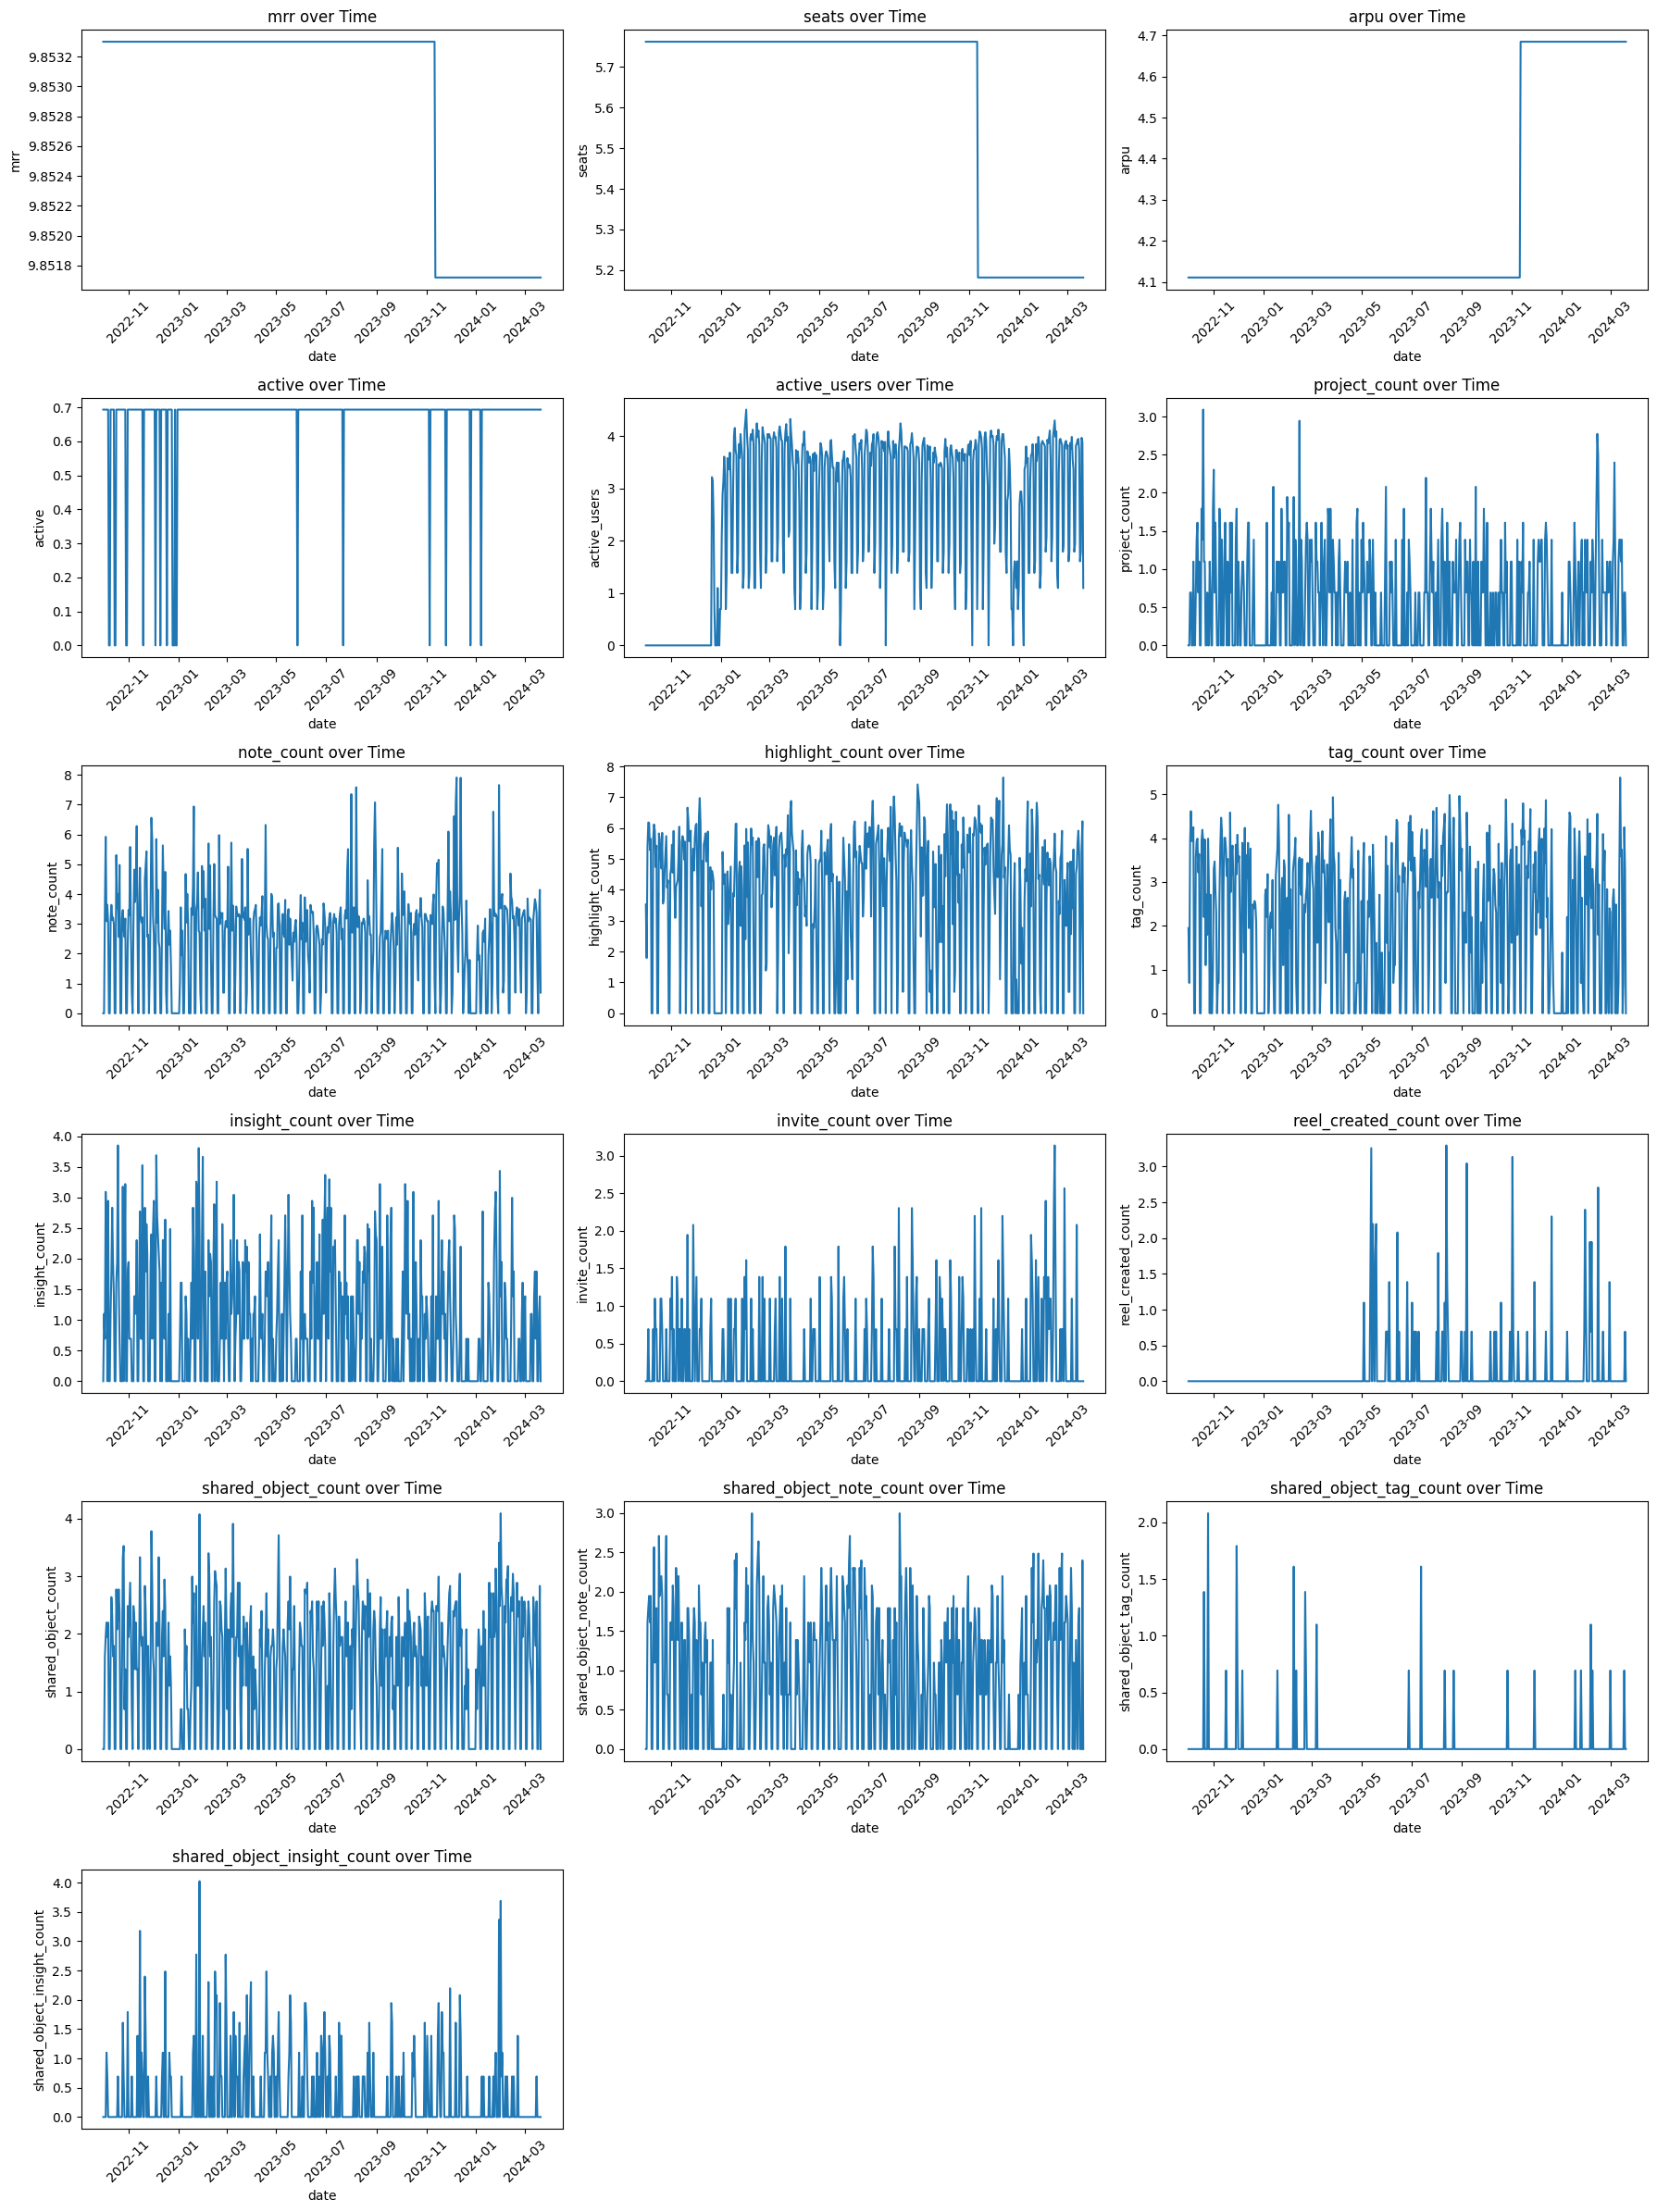

<Figure size 1000x1000 with 0 Axes>

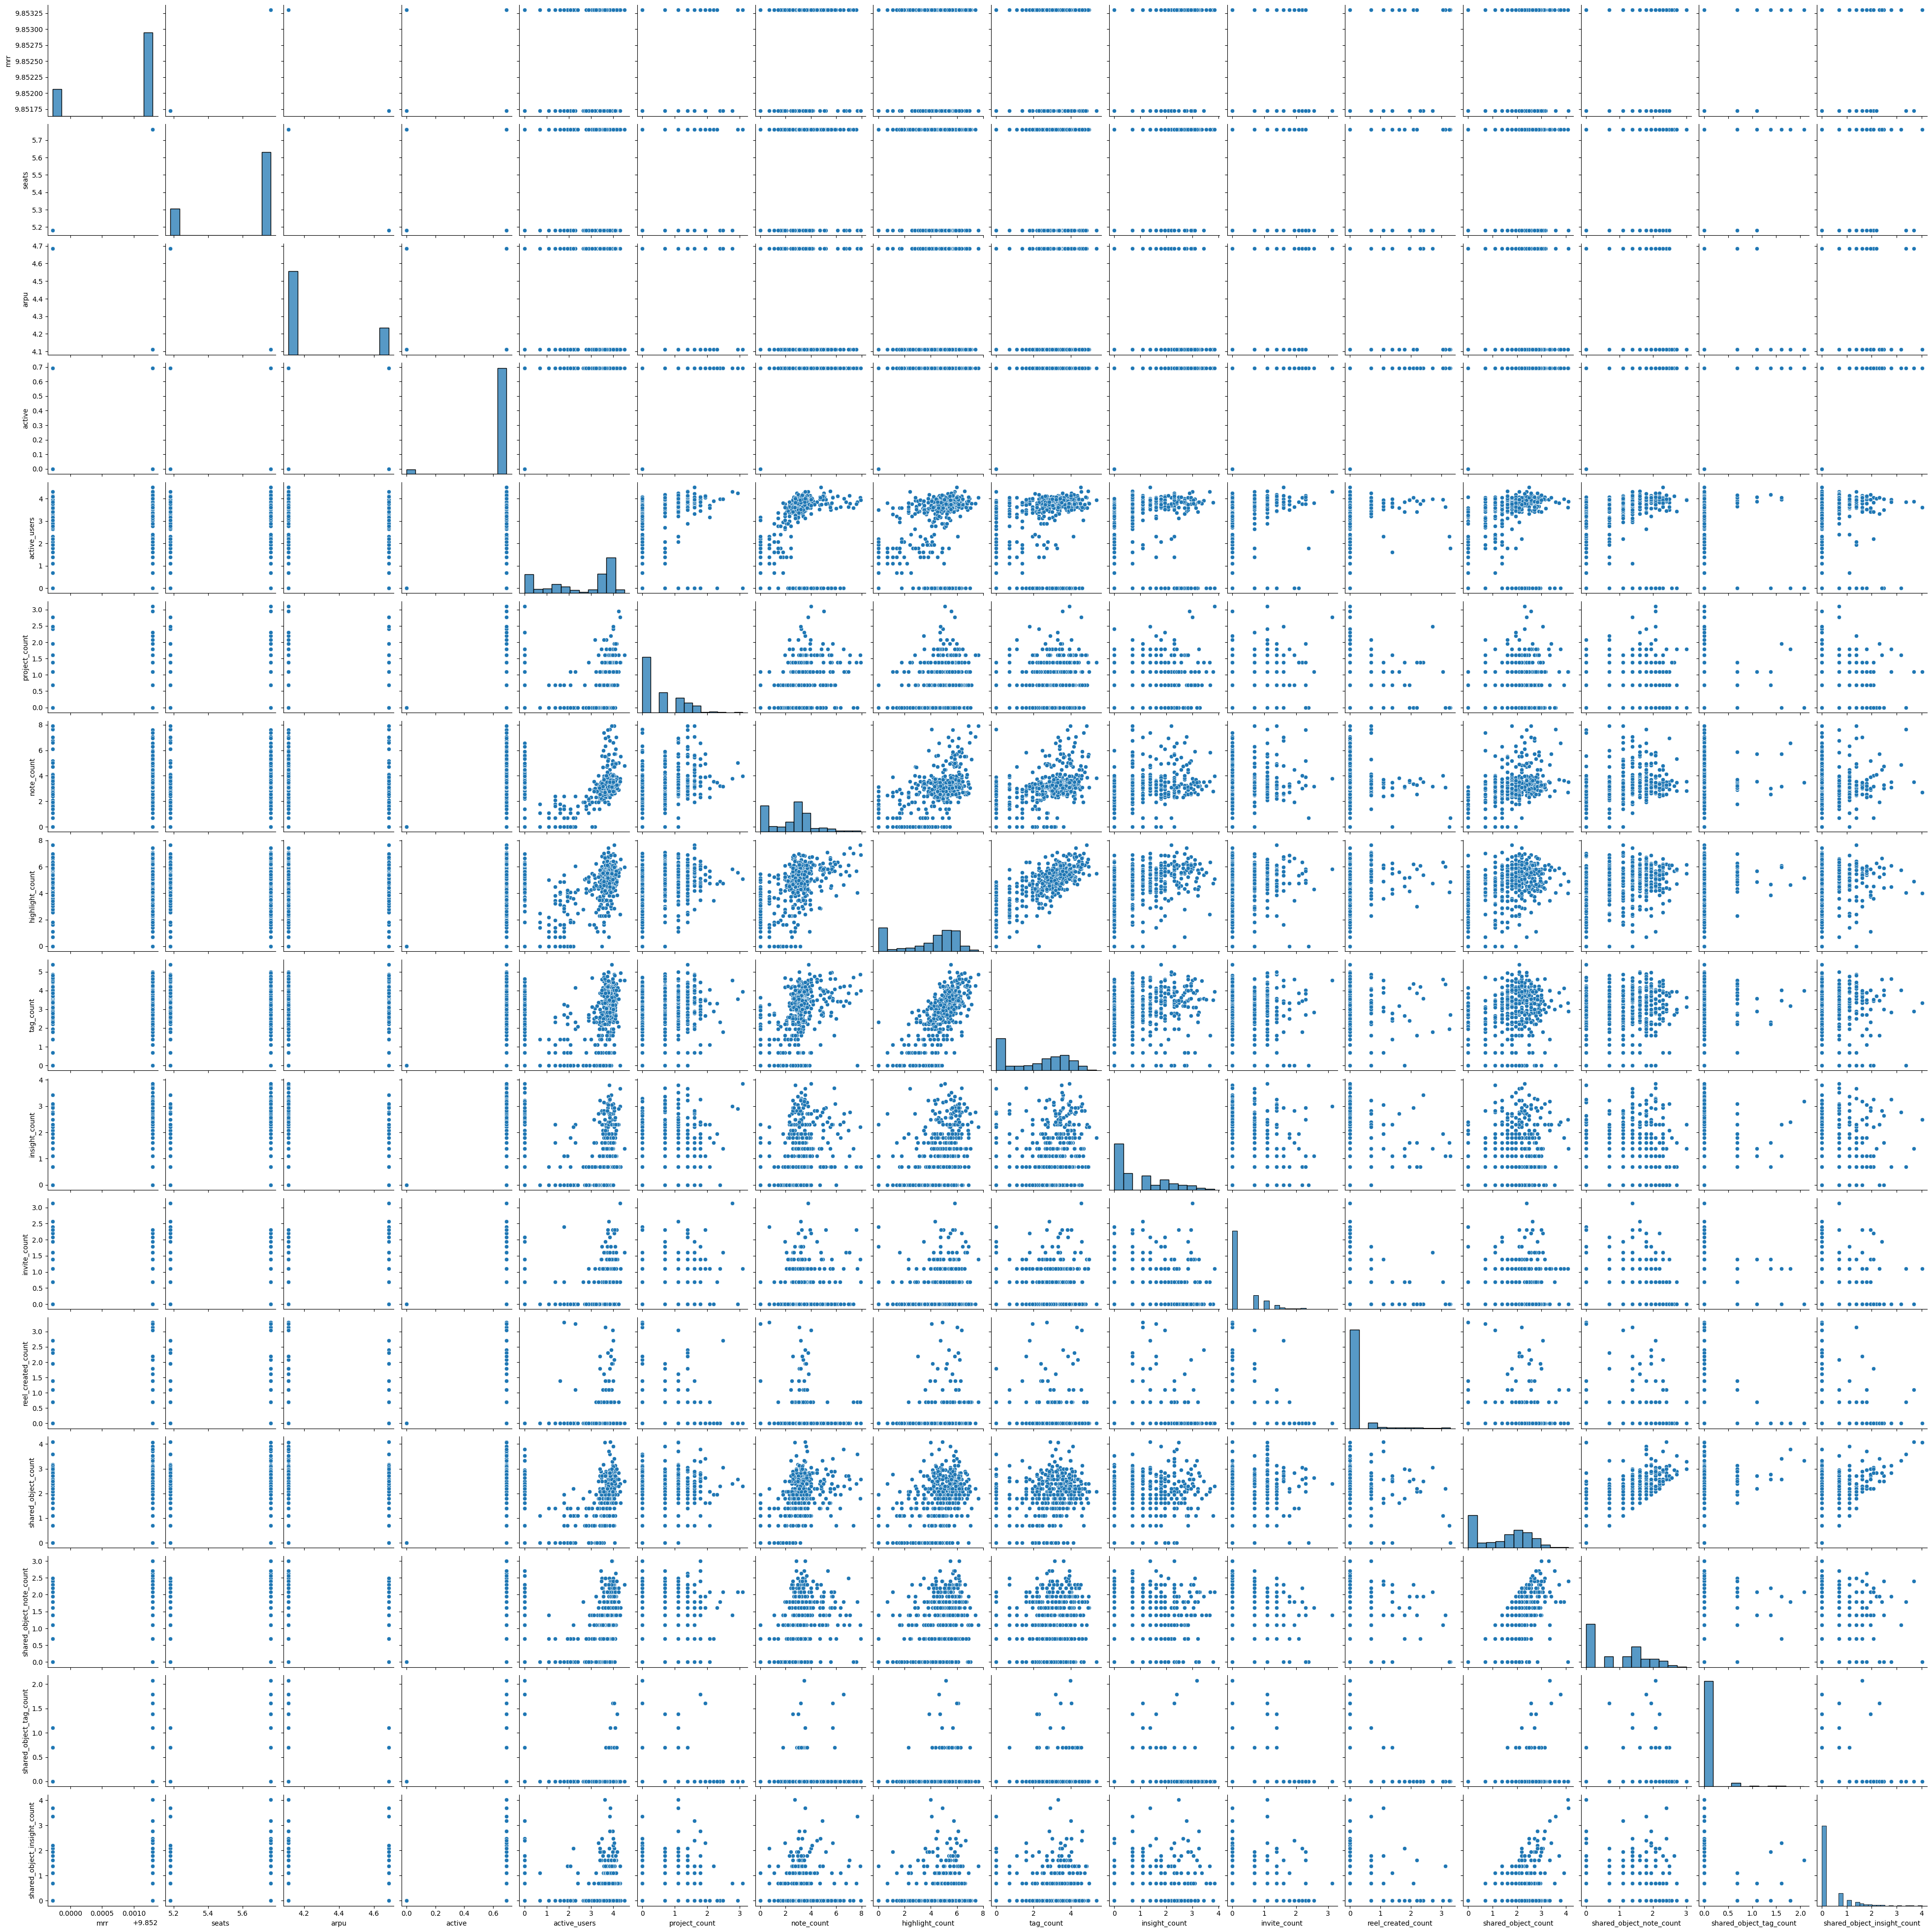

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_all_variables(data, date_column_name):
    # Ensure the date column is in datetime format
    data[date_column_name] = pd.to_datetime(data[date_column_name])
    
    # Select numeric columns, excluding the date column if it's mistakenly included as numeric
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Determine the number of rows/columns for the subplot grid
    n = len(numeric_cols)
    n_cols = 3  # You can adjust this value based on your preference or screen width
    n_rows = n // n_cols + (n % n_cols > 0)
    
    # Create a figure to hold the subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    # Plot each numeric variable against the date column in its subplot
    for i, col in enumerate(numeric_cols):
        sns.lineplot(x=date_column_name, y=col, data=data, ax=axes[i])
        axes[i].set_title(f"{col} over Time")
        axes[i].set_xlabel(date_column_name)
        axes[i].set_ylabel(col)
        axes[i].tick_params(axis='x', rotation=45)  # Rotate date labels for better readability
    
    # Hide any unused subplot axes
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Plot a pair plot of all numeric variables
    plt.figure(figsize=(10, 10))
    sns.pairplot(data[numeric_cols])
    plt.show()


# Example usage
plot_all_variables(data, 'date')


### EDA

Adding data with properties: 15 processes, 538 samples, 1 replications
overwriting existing data

---------------------------- (1) include target candidates


No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates

---------------------------- (3) prune source candidate

---------------------------- (4) final statistics

---------------------------- (1) include target candidates


No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates

---------------------------- (3) prune source candidate

---------------------------- (4) final statistics

---------------------------- (1) include target candidates


---------------------------- (2) include source candidates

---------------------------- (3) prune source candidate

---------------------------- (4) final statistics

---------------------------- (1) include target candida

ValueError: Invalid format specifier '.2f%' for object of type 'float'

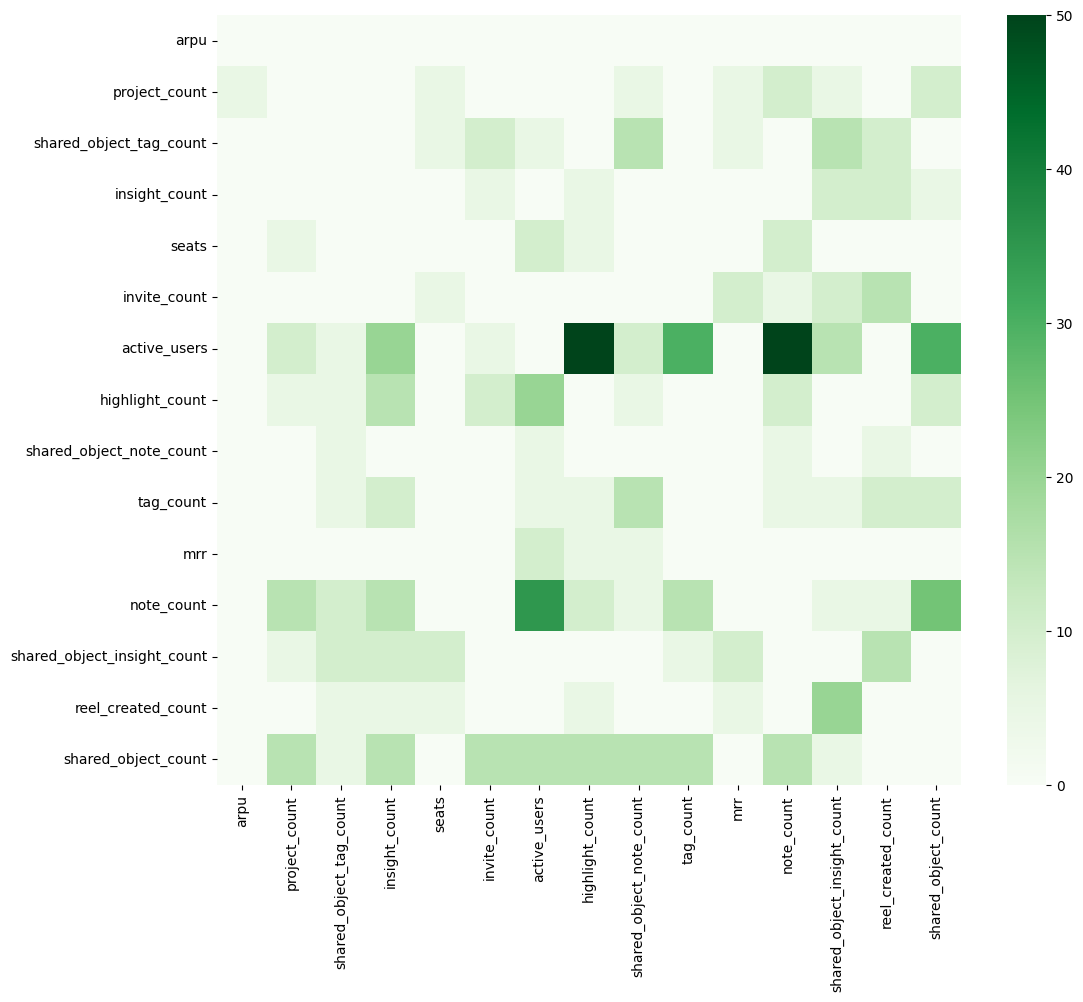

In [26]:
# from jpype import *
# jarLocation = "/Users/patricksweeney/JIDT/infodynamics.jar"
# startJVM(getDefaultJVMPath(), "-ea", "-Xmx4024M", "-Djava.class.path=" + jarLocation, convertStrings=True)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

def get_global_node_mapping(data, date_col):
    data_clean = data.dropna(axis=1, how='all').dropna(axis=0).sort_values(by=date_col)
    var_cols = [col for col in data_clean if pd.api.types.is_numeric_dtype(data_clean[col]) and data_clean[col].var() != 0]
    node_mapping = {i: var for i, var in enumerate(var_cols)}
    return node_mapping

def plot_cumulative_matrix(matrix, node_mapping, total_workspaces):
    percentage_matrix = (matrix / total_workspaces) * 100  # Convert counts to percentage
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(percentage_matrix, annot=True, cmap='Greens', cbar=True,
                xticklabels=[node_mapping[i] for i in range(len(node_mapping))],
                yticklabels=[node_mapping[i] for i in range(len(node_mapping))],
                fmt=".2f%",  # Corrected format specifier
                ax=ax)


    plt.xlabel('Children (Effect)')
    plt.ylabel('Parents (Cause)')
    plt.title('Cumulative Transfer Entropy Matrix as Percentage of Total Workspaces')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

def tally_effective_networks(data, date_col, num_workspaces=20):
    node_mapping_global = get_global_node_mapping(data, date_col)
    max_nodes = len(node_mapping_global)
    tally_matrix = np.zeros((max_nodes, max_nodes))
    
    unique_workspace_ids = data['workspace_id'].unique()
    total_workspaces = min(len(unique_workspace_ids), num_workspaces)  # Adjusted for total workspaces processed
    
    for count, workspace_id in enumerate(unique_workspace_ids[:total_workspaces], start=1):
        workspace_data = data[data['workspace_id'] == workspace_id]
        results = effective_network(workspace_data, date_col, node_mapping_global)

        if results is None:
            continue
        
        print(f"Workspace number: {count} complete")
        for target in results.targets_analysed:
            sources = results.get_target_sources(target=target, fdr=False)
            for source in sources:
                tally_matrix[source, target] += 1
    
    plot_cumulative_matrix(tally_matrix, node_mapping_global, total_workspaces)
    return tally_matrix, node_mapping_global

def effective_network(workspace_data, date_col, node_mapping_global):
    workspace_data = workspace_data.dropna().sort_values(by=date_col).drop(columns=[date_col])
    workspace_data = workspace_data[[col for col in workspace_data if col in node_mapping_global.values()]]
    
    if workspace_data.empty:
        print("Workspace data is empty after preprocessing.")
        return None
    
    np_workspace_data = np.array(workspace_data).T.reshape(len(node_mapping_global), -1, 1)
    idtxl_workspace_data = Data(np_workspace_data, dim_order='psr')
    
    settings = {'cmi_estimator': 'JidtGaussianCMI', 'max_lag_sources': 5, 'min_lag_sources': 1, 'verbose': False}
    network_analysis = MultivariateTE()
    results = network_analysis.analyse_network(settings=settings, data=idtxl_workspace_data)

    return results


tally_matrix, node_mapping_global = tally_effective_networks(data, 'date')


# HMM

- 3 hidden states
- 5 observation variables per state
    - Negative binomially distributed emissions with $\mu$ and $r$ for each modality
    - Model them jointly not independently


**Prior**

**Likelihood**

**Posterior—variational**

### Generative process


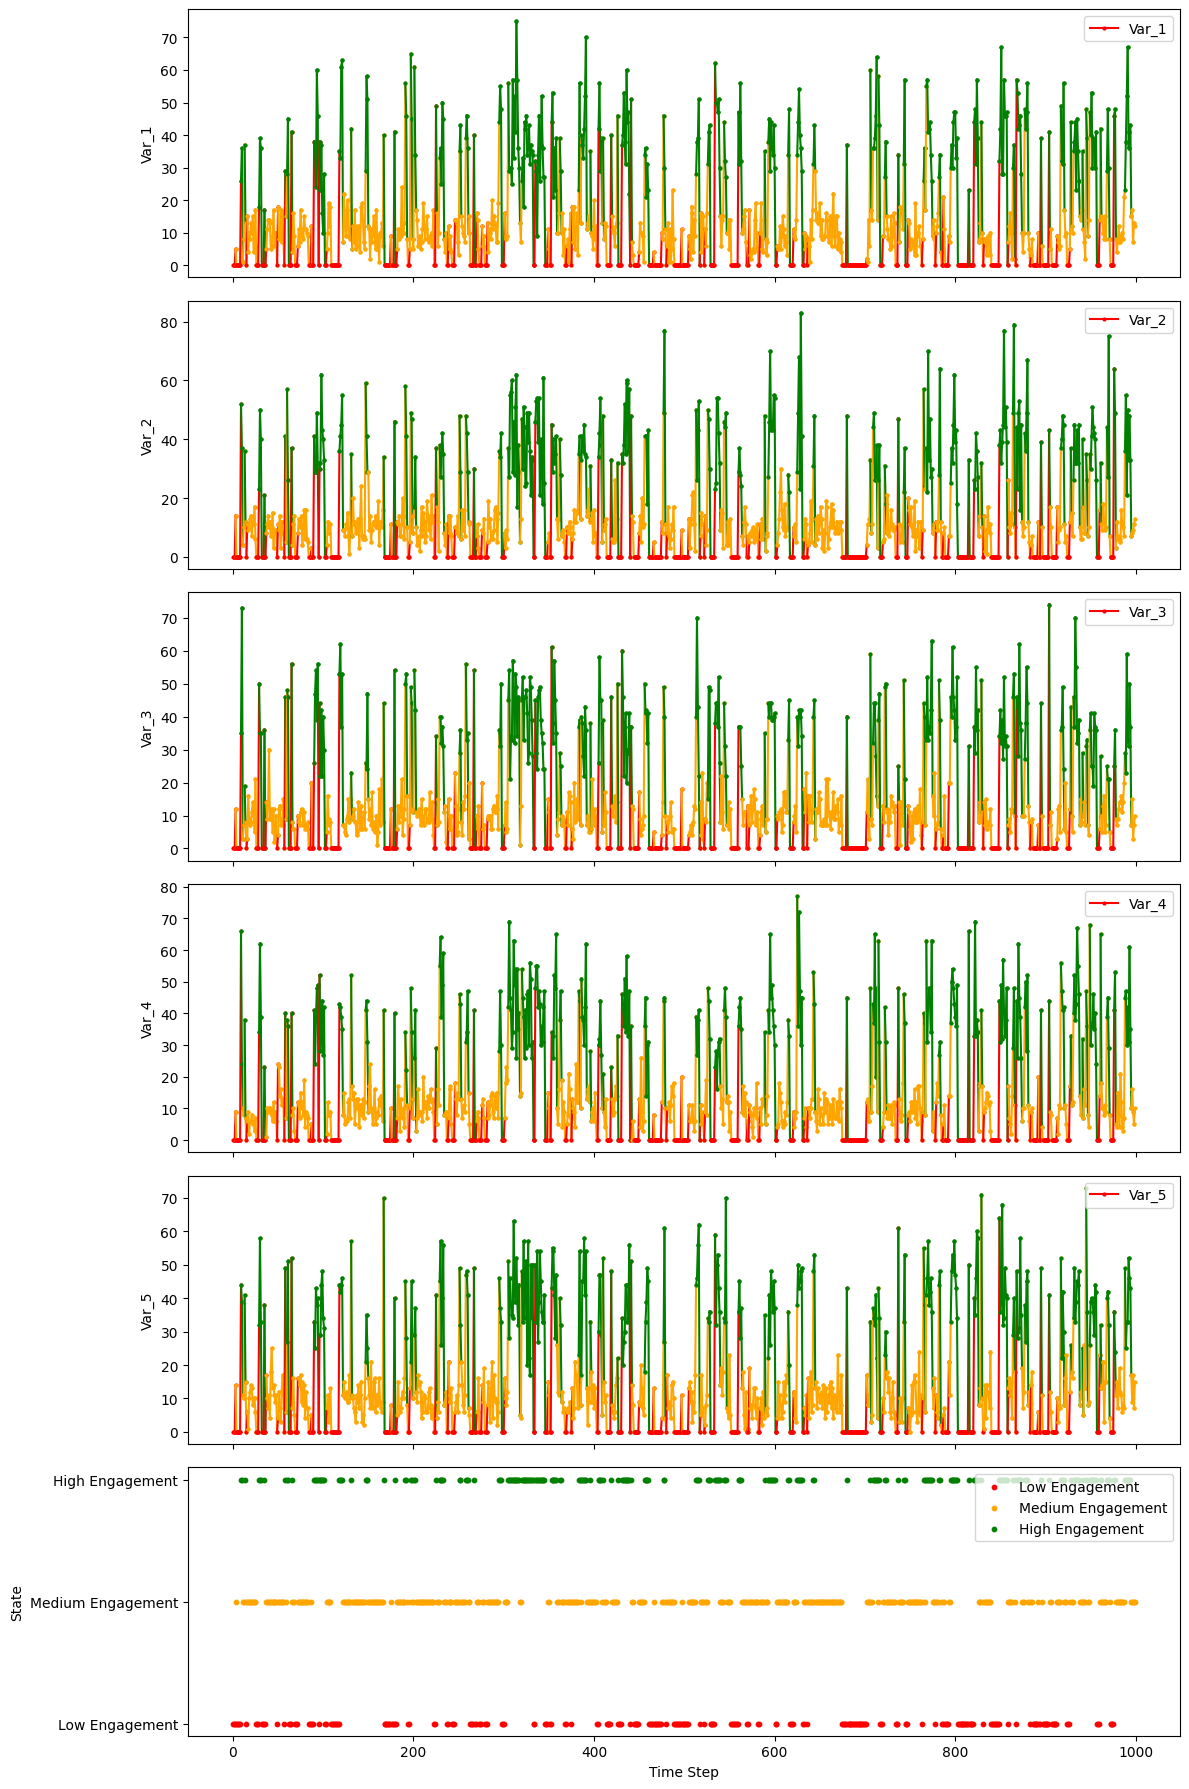

,Var_1,Var_2,Var_3,Var_4,Var_5,State,State Label
0,0.0,0.0,0.0,0.0,0.0,0,Low Engagement
1,0.0,0.0,0.0,0.0,0.0,0,Low Engagement
2,0.0,0.0,0.0,0.0,0.0,0,Low Engagement
3,5.0,14.0,12.0,9.0,14.0,1,Medium Engagement
4,0.0,0.0,0.0,0.0,0.0,0,Low Engagement


In [50]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.distributions.negative_binomial import NegativeBinomial
from torch.distributions import Categorical

def initialize_parameters(num_states=3, num_observation_vars=5):
    """
    Initialize model parameters with explicit values for demonstration.
    """
    # Simplified transition probabilities for demonstration
    transition_probs = torch.tensor([[0.7, 0.2, 0.1],
                                      [0.1, 0.8, 0.1],
                                      [0.1, 0.2, 0.7]])
    
    # Uniform initial state probabilities
    initial_state_probs = torch.tensor([1/3, 1/3, 1/3])
    
    # Manually set emission means to reflect state 'highness'
    emission_means = torch.tensor([[0, 0, 0, 0, 0],  # Low Engagement
                                   [10, 10, 10, 10, 10],  # Medium Engagement
                                   [40, 40, 40, 40, 40]])  # High Engagement
    
    emission_rs = torch.tensor([[5, 5, 5, 5, 5],  # Assuming same dispersion for simplicity
                                [10, 10, 10, 10, 10],
                                [20, 20, 20, 20, 20]])
    
    return transition_probs, initial_state_probs, emission_means, emission_rs



def simulate_markov_chain(transition_probs, initial_state_probs, num_time_steps):
    """
    Simulate a sequence of states for a Markov chain given transition probabilities.
    """
    states = torch.zeros(num_time_steps, dtype=torch.long)
    states[0] = Categorical(initial_state_probs).sample()  # Initial state
    
    for t in range(1, num_time_steps):
        state = states[t-1]
        next_state_prob = transition_probs[state]
        states[t] = Categorical(next_state_prob).sample()  # Next state based on the transition probabilities
    
    return states

def generate_observations(states, emission_means, emission_rs):
    """
    Generate observations based on the current state and Negative Binomial distribution parameters.
    """
    num_time_steps = states.size(0)
    observations = torch.zeros((num_time_steps, 5))
    
    for t in range(num_time_steps):
        state = states[t]
        for var in range(5):
            mu = emission_means[state, var]
            r = emission_rs[state, var]
            p = mu / (mu + r)  # Probability of success
            observations[t, var] = NegativeBinomial(total_count=r, probs=p).sample()
    
    return observations

# Parameters
num_states = 3
num_observation_vars = 5
num_time_steps = 1000

# Initialize model parameters
transition_probs, initial_state_probs, emission_means, emission_rs = initialize_parameters(num_states, num_observation_vars)

# Simulate state sequence
states = simulate_markov_chain(transition_probs, initial_state_probs, num_time_steps)

# Generate observations
observations = generate_observations(states, emission_means, emission_rs)

# Convert to DataFrame
data = pd.DataFrame(observations.numpy(), columns=[f'Var_{i+1}' for i in range(5)])
data['State'] = states.numpy()

# Assuming 'data' contains the observations and state information

# Map numerical states to engagement levels
state_labels = {0: 'Low Engagement', 1: 'Medium Engagement', 2: 'High Engagement'}
data['State Label'] = data['State'].map(state_labels)

# Plotting
fig, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

# Define colors for each state
state_colors = {0: 'red', 1: 'orange', 2: 'green'}

# Plot each observation variable with colors based on states
for i, col in enumerate([f'Var_{i+1}' for i in range(5)]):
    for t in range(num_time_steps - 1):  # Loop over all time steps
        state_at_t = data['State'][t]
        # Draw line segment from time t to t+1 with color based on state
        axes[i].plot([t, t+1], [data[col][t], data[col][t+1]], marker='o', linestyle='-', markersize=2, color=state_colors[state_at_t])
    axes[i].set_ylabel(col)
    axes[i].legend([col], loc="upper right")

# Plot the states with labels in the last subplot
for key, label in state_labels.items():
    state_data = data[data['State'] == key]
    # Use scatter plot for states to show individual points
    axes[5].scatter(state_data.index, state_data['State'], label=label, color=state_colors[key], s=10)

axes[5].set_yticks([0, 1, 2])
axes[5].set_yticklabels(['Low Engagement', 'Medium Engagement', 'High Engagement'])
axes[5].set_ylabel('State')
axes[5].set_xlabel('Time Step')
axes[5].legend(loc="upper right")

plt.tight_layout()
plt.show()

data.head()

### Generative model

In [79]:
import torch
from torch.distributions import NegativeBinomial
from torch.optim import Adam

# Example usage
num_states = 3
num_observation_vars = 5
observations = data[[f'Var_{i+1}' for i in range(5)]].values  # Extracting observations from the DataFrame

# Assuming 'data' is a pandas DataFrame
observations_np = data[[f'Var_{i+1}' for i in range(num_observation_vars)]].values  # Extracting observations as a NumPy array
observations = torch.tensor(observations_np, dtype=torch.float)  # Convert to a PyTorch tensor



def initialize_parameters(num_states, num_observation_vars):
    # Transition probabilities, ensure they sum to 1 across columns
    transition_probs = torch.randn(num_states, num_states, requires_grad=True)
    transition_probs = torch.nn.functional.softmax(transition_probs, dim=1)
    
    # Initial state probabilities, ensure they sum to 1
    initial_state_probs = torch.randn(num_states, requires_grad=True)
    initial_state_probs = torch.nn.functional.softmax(initial_state_probs, dim=0)
    
    # Emission means, positive values
    emission_means = torch.abs(torch.randn(num_states, num_observation_vars, requires_grad=True))
    
    # Emission rs (rate parameters), positive values
    emission_rs = torch.abs(torch.randn(num_states, num_observation_vars, requires_grad=True))
    
    return transition_probs, initial_state_probs, emission_means, emission_rs

def initialize_hmm(num_states, num_observation_vars):
    transition_probs, initial_state_probs, emission_means, emission_rs = initialize_parameters(num_states, num_observation_vars)
    
    observation_model = {
        'emission_means': emission_means,
        'emission_rs': emission_rs
    }
    
    return transition_probs, initial_state_probs, observation_model



def baum_welch(observations, transition_probs, initial_state_probs, observation_model, num_iterations=100):
    def compute_forward_probabilities(observations, transition_probs, initial_state_probs, emission_means, emission_rs):
        """
        Compute forward probabilities for an HMM with Negative Binomial emissions.
        """
        num_states = transition_probs.shape[0]
        num_time_steps = observations.shape[0]
        forward_probs = torch.zeros((num_time_steps, num_states))

        # Compute emission probabilities for the first observation
        for state in range(num_states):
            mu = emission_means[state]
            r = emission_rs[state]
            p = mu / (mu + r)
            dist = NegativeBinomial(total_count=r, probs=p)
            # Sum log probabilities across all observation variables for multidimensional observations
            log_prob = dist.log_prob(observations[0]).sum()
            forward_probs[0, state] = initial_state_probs[state] * torch.exp(log_prob)


        # Iterate through the rest of the observations
        for t in range(1, num_time_steps):
            for curr_state in range(num_states):
                sum_prob = 0
                for prev_state in range(num_states):
                    transition_prob = transition_probs[prev_state, curr_state]
                    mu = emission_means[curr_state]
                    r = emission_rs[curr_state]
                    p = mu / (mu + r)  # Convert mean and r to probability for Negative Binomial
                    dist = NegativeBinomial(total_count=r, probs=p)
                    emission_prob = dist.log_prob(observations[t]).exp()
                    sum_prob += forward_probs[t-1, prev_state] * transition_prob * emission_prob
                forward_probs[t, curr_state] = sum_prob

        return forward_probs

    def compute_backward_probabilities(observations, transition_probs, emission_means, emission_rs):
        """
        Compute backward probabilities for an HMM with Negative Binomial emissions.
        """
        num_states = transition_probs.shape[0]
        num_time_steps = observations.shape[0]
        backward_probs = torch.zeros((num_time_steps, num_states))

        # Initialize backward probabilities for the last time step
        backward_probs[num_time_steps - 1, :] = 1  # Since the probability of the sequence after the last observation is 1

        # Compute backward probabilities from t = T-2 down to t = 0
        for t in range(num_time_steps - 2, -1, -1):
            for curr_state in range(num_states):
                sum_prob = 0
                for next_state in range(num_states):
                    transition_prob = transition_probs[curr_state, next_state]
                    mu = emission_means[next_state]
                    r = emission_rs[next_state]
                    p = mu / (mu + r)  # Convert mean and r to probability for Negative Binomial
                    dist = NegativeBinomial(total_count=r, probs=p)
                    emission_prob = dist.log_prob(observations[t + 1]).exp()
                    sum_prob += transition_prob * emission_prob * backward_probs[t + 1, next_state]
                backward_probs[t, curr_state] = sum_prob

        return backward_probs

    def e_step(observations, transition_probs, initial_state_probs, emission_means, emission_rs, forward_probs, backward_probs):
        num_states = transition_probs.shape[0]
        num_time_steps = observations.shape[0]
        
        gamma = torch.zeros((num_time_steps, num_states))
        xi = torch.zeros((num_time_steps - 1, num_states, num_states))
        
        for t in range(num_time_steps):
            # Norm factor for gamma to ensure stability
            norm_factor_gamma = torch.sum(forward_probs[t, :] * backward_probs[t, :]) + 1e-9
            
            for i in range(num_states):
                gamma[t, i] = (forward_probs[t, i] * backward_probs[t, i]) / norm_factor_gamma
                        
                if t < num_time_steps - 1:
                    for j in range(num_states):
                        mu = emission_means[j]
                        r = emission_rs[j]
                        p = mu / (mu + r)
                        dist = NegativeBinomial(total_count=r, probs=p)
                        emission_prob = dist.log_prob(observations[t + 1]).exp()
                        
                        xi[t, i, j] = forward_probs[t, i] * transition_probs[i, j] * emission_prob * backward_probs[t + 1, j]
            
            # Normalize xi at each time step t to ensure the sum over all i, j equals 1
            if t < num_time_steps - 1:
                norm_factor_xi = torch.sum(xi[t, :, :]) + 1e-9
                xi[t, :, :] /= norm_factor_xi
                
        return gamma, xi


    def m_step(observations, gamma, xi, num_states, num_observation_vars, learning_rate=0.01, num_epochs=100):
        # Assumes transition_probs is now a parameter that requires gradients
        transition_probs = torch.randn(num_states, num_states, requires_grad=True)
        transition_probs = torch.nn.functional.softmax(transition_probs, dim=1)
        
        # Emission parameters
        emission_means = torch.rand((num_states, num_observation_vars), requires_grad=True)
        emission_rs = torch.rand((num_states, num_observation_vars), requires_grad=True)
        
        # Optimizer now includes transition_probs, emission_means, and emission_rs
        optimizer = Adam([transition_probs, emission_means, emission_rs], lr=learning_rate)
        
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss = 0  # Negative log-likelihood

            for t in range(observations.shape[0]):
                for state in range(num_states):
                    mu = emission_means[state]
                    r = emission_rs[state]
                    p = mu / (mu + r)
                    dist = NegativeBinomial(total_count=r, probs=p)
                    log_prob = dist.log_prob(observations[t])
                    
                    # Update loss using gamma to weight the log_prob
                    loss -= (gamma[t, state] * log_prob).sum()

            # Additional term for the transition probabilities contribution to the loss
            # This can be computed using xi and transition_probs if needed

            loss.backward()
            optimizer.step()

            # Apply softmax to ensure transition_probs remain valid probabilities
            with torch.no_grad():
                transition_probs = torch.nn.functional.softmax(transition_probs, dim=1)
                transition_probs.requires_grad = True

        # Detach updated parameters from the graph
        updated_transition_probs = transition_probs.detach()
        updated_emission_means = emission_means.detach()
        updated_emission_rs = emission_rs.detach()
        
        return updated_transition_probs, updated_emission_means, updated_emission_rs


    for iteration in range(num_iterations):
        # Extract current emission parameters from observation_model
        emission_means = observation_model['emission_means']
        emission_rs = observation_model['emission_rs']

        # Compute Forward and Backward Probabilities
        forward_probs = compute_forward_probabilities(observations, transition_probs, initial_state_probs, emission_means, emission_rs)
        backward_probs = compute_backward_probabilities(observations, transition_probs, emission_means, emission_rs)
        
        # E-step: Calculate expected transitions (xi) and state occupancies (gamma)
        gamma, xi = e_step(observations, transition_probs, initial_state_probs, emission_means, emission_rs, forward_probs, backward_probs)
        
        # M-step: Update model parameters based on expectations
        updated_transition_probs, updated_emission_means, updated_emission_rs = m_step(observations, gamma, xi, num_states, num_observation_vars)
        
        # Update the parameters for the next iteration
        transition_probs = updated_transition_probs
        observation_model['emission_means'] = updated_emission_means
        observation_model['emission_rs'] = updated_emission_rs

    # After the loop, all the parameters including initial_state_probs are returned with the updated observation_model.
    # Note: initial_state_probs does not get updated in this version. If updating is required, it should be included in the loop.
    return transition_probs, initial_state_probs, observation_model
    

def viterbi_algorithm(observations, transition_probs, initial_state_probs, observation_model):
    """
    State estimation with the Viterbi algorithm for an HMM with Negative Binomial emissions.
    """
    num_states = transition_probs.shape[0]
    num_observations = observations.shape[0]
    log_transition_probs = torch.log(transition_probs)
    
    # Initialize the matrices to store the maximum probabilities and the paths
    log_probs = torch.full((num_observations, num_states), float('-inf'))
    paths = torch.zeros((num_observations, num_states), dtype=torch.long)
    
    # Emission probability for the first observation
    for state in range(num_states):
        mu = emission_means[state]
        r = emission_rs[state]
        p = mu / (mu + r)
        dist = NegativeBinomial(total_count=r, probs=p)
        # Assuming observations[0] can be a vector and we aggregate log probs, for example, by summing
        log_prob = dist.log_prob(observations[0]).sum()  # Adjust based on your model's specifics
        forward_probs[0, state] = initial_state_probs[state] * torch.exp(log_prob)

    
    # Fill in the log_probs matrix and paths using dynamic programming
    for t in range(1, num_observations):
        for curr_state in range(num_states):
            for prev_state in range(num_states):
                mu = observation_model['emission_means'][curr_state]
                r = observation_model['emission_rs'][curr_state]
                p = mu / (mu + r)
                dist = NegativeBinomial(total_count=r, probs=p)
                log_prob = log_probs[t-1, prev_state] + log_transition_probs[prev_state, curr_state] + dist.log_prob(observations[t])
                
                if log_prob > log_probs[t, curr_state]:
                    log_probs[t, curr_state] = log_prob
                    paths[t, curr_state] = prev_state
    
    # Backtracking to find the most probable path
    estimated_states = torch.zeros(num_observations, dtype=torch.long)
    estimated_states[-1] = torch.argmax(log_probs[-1, :])  # Start with the most probable last state
    
    for t in range(num_observations - 2, -1, -1):
        estimated_states[t] = paths[t + 1, estimated_states[t + 1]]
    
    return estimated_states


# Initialize the HMM
transition_probs, initial_state_probs, observation_model = initialize_hmm(num_states, num_observation_vars)

# Perform parameter estimation with the Baum-Welch algorithm
transition_probs, observation_model = baum_welch(observations, transition_probs, initial_state_probs, observation_model)

# State estimation with the Viterbi algorithm
estimated_states = viterbi_algorithm(observations, transition_probs, initial_state_probs, observation_model)



RuntimeError: expand(torch.FloatTensor{[5]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)